In [1]:
import tensorflow as tf
import numpy as np

In [11]:
input_shape = (4,28,28,3)
x_input = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(
filters = 2, kernel_size = 3, 
activation = 'relu', input_shape = input_shape[1:])(x_input)

In [5]:
y.shape

TensorShape([4, 26, 26, 2])

In [14]:
CNN = tf.keras.models.Sequential()
CNN.add(tf.keras.layers.Conv2D(
    filters = 2, kernel_size = 4, strides = (1,1),
padding = 'valid', activation = 'relu', use_bias = True, input_shape = input_shape[1:]))
CNN.add(tf.keras.layers.Conv2D(filters = 2, kernel_size = 3, strides = (1,1),
                              activation = 'relu', use_bias = True))
CNN.add(tf.keras.layers.Conv2D(filters = 2, kernel_size = 3, strides = (2,2), 
                              activation = 'relu', use_bias = False))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
CNN.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer='adam')
CNN.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 25, 25, 2)         98        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 2)         38        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 2)         36        
_________________________________________________________________
flatten (Flatten)            (None, 242)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 243       
Total params: 415
Trainable params: 415
Non-trainable params: 0
_________________________________________________________________


In [16]:
CNN(x_input)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.5849923 ],
       [0.72693104],
       [0.4394684 ],
       [0.5912767 ]], dtype=float32)>

In [18]:
x = tf.random.normal((32, 28,28,3))
CNN(x).shape

TensorShape([32, 1])

```FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})```  


- 아래는 tensorflow_dataset에 저장되어 있는 사용 가능한 이미지 데이터를 사용하는 방법이다.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)


228818944/228813984 [==============================] - 8s 0us/step


In [5]:
data_dir

WindowsPath('C:/Users/이지혜/.keras/datasets/flower_photos')

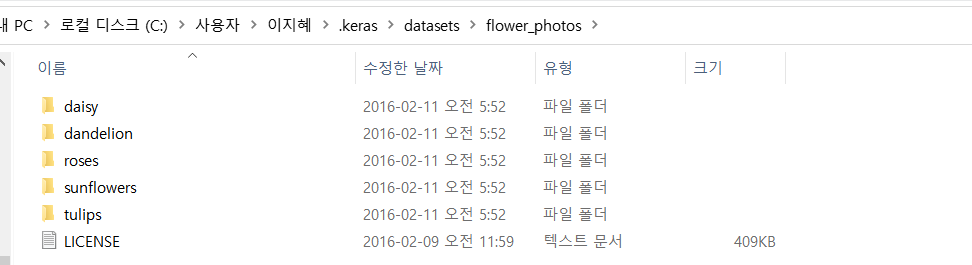

- 이미지 데이터는 위와 같은 경로로 저장이 되고, 이에 따라서 class, 즉 y의 label값을 저 해당 파일 명으로 설정해 주면 되는 것이다.  
```glob('*/*')```  
를 이용해서 이미지의 저장 경로의 이름을 특정지어 준다.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


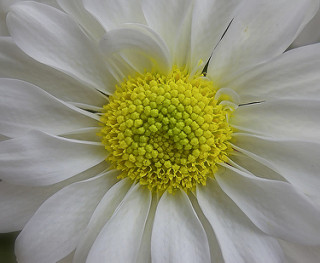

In [11]:
import PIL
PIL.Image.open(list(data_dir.glob('daisy/*.jpg'))[0])

```tf.keras.image.preprocessing```을 이용해서 이미지를 tensorflow model에 사용이 가능한 dataset으로 개선을 해 준다.
- 이때 중요한 것은 이미지가 저장이 되어 있는 경로를 이용해서 이미지 데이터를 이용할 것이기 때문에 ```tf.keras.preprocessing,image_dataset_from_directory```를 이용해야 한다는 것이다.  

- 또한 파이썬에서는 이미지를 처리할 수 있도록 해주는 PIL,즉 Pillow라는 모듈을 제공해 준다.
    - Pillow는 파이썬 이미징 라이브러리로서 여러 이미지 파일 포맷을 지원하고, 이미지 내부 데이타를 엑세스할 수 있게 하며, 다양한 이미지 처리 기능을 제공하고 있다
    1. PIL.Image.open()
    2. PIL.Image.new()
    3. PIL.Image.save()

In [15]:
img = PIL.Image.open(list(data_dir.glob('daisy/*.jpg'))[0])
img.size

(320, 263)

```
batch_size = 64
img_height, img_width = 180, 180
train_x = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'Train',
    seed = 100,
    image_size = (img_height, img_width),
    batch_size = batch_size)
```  
위와 같이 하면 되는데, 
**그러나 안타깝게도  
AttributeError: module 'tensorflow_core.keras.preprocessing' has no attribute 'image_dataset_from_directory' 와 같은 경고문이 뜨는데, nightly version만 제공되는 모듈이기 때문이다.**  


- 그래서 그냥 keras의 Image Data Generator을 이용하면 된다.
- class_mode설정을 제대로 해 주어야 하는데, 이중 클래스는 binary, 다중클래스+one hot encoding은 categorical, autoencoder에는 input, 다중integer class는 sparse를 쓴다.

In [229]:
batch_size = 64
input_height, input_width = 50, 50

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = 0.2, height_shift_range = 0.2,
    fill_mode = 'nearest', rescale = 1/255.0,
    zoom_range = 0.2, validation_split = 0.2, horizontal_flip = True, channel_shift_range = 0.3)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = (input_height, input_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

Found 3670 images belonging to 5 classes.


train_generator은 이제 (x,y)형태의 tuple을 담고있는, 그와중에 x가 (batch_size, target_height, target_width, channels)의 shape를 갖고 있는 이미지의 묶음을 담고 있으며 y는 그에 해당하는 corresponding label의 내용을 갖는 numpy array이다.

In [234]:
Model = tf.keras.models.Sequential()
Model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 4,
                                strides = (1,1), activation = 'relu', padding = 'valid',
                                input_shape = (input_height, input_width, 3)))
Model.add(tf.keras.layers.MaxPooling2D(pool_size = (4,4), 
                                     strides = (1,1), padding = 'valid'))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                strides = (1,1), padding = 'valid', activation = 'relu'))
Model.add(tf.keras.layers.BatchNormalization())
Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dense(32, activation = 'relu'))
Model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

In [235]:
Model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 47, 47, 64)        3136      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 42, 42, 32)        18464     
_________________________________________________________________
batch_normalization_8 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
flatten_9 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1806368   
_________________________________________________________________
dense_16 (Dense)             (None, 5)               

- categorical_crossentropy는 다중 분류 손실함수라서 마지막에 class별로 각각의 확률값이 batch단위로 묶여서 출력이 된다. 
    - one-hot encoding 클래스를 사용한다.
- 반면 sparse_categorical_crossentropy는 다중 분류 손실함수라는 것은 동일하지만 integer type class이기 떄문에 one-hot-encoding과정을 하지 않아도 된다.
    - integer type 클래스를 사용한다.

In [236]:
Model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')


In [237]:
history = Model.fit(train_generator, epochs = 10)

  ...
    to  
  ['...']
Train for 58 steps
Epoch 1/10
58/58 [==============================] - 16s 269ms/step - loss: 1.7108 - accuracy: 0.4014
Epoch 2/10
58/58 [==============================] - 19s 334ms/step - loss: 1.2237 - accuracy: 0.5079
Epoch 3/10
58/58 [==============================] - 20s 351ms/step - loss: 1.1242 - accuracy: 0.5439
Epoch 4/10
58/58 [==============================] - 20s 352ms/step - loss: 1.1043 - accuracy: 0.5649
Epoch 5/10
58/58 [==============================] - 20s 350ms/step - loss: 1.0551 - accuracy: 0.5820
Epoch 6/10
58/58 [==============================] - 20s 352ms/step - loss: 1.0072 - accuracy: 0.5965
Epoch 7/10
58/58 [==============================] - 20s 351ms/step - loss: 1.0064 - accuracy: 0.5997
Epoch 8/10
58/58 [==============================] - 20s 352ms/step - loss: 0.9986 - accuracy: 0.5986
Epoch 9/10
58/58 [==============================] - 20s 351ms/step - loss: 0.9771 - accuracy: 0.6112
Epoch 10/10
58/58 [============================

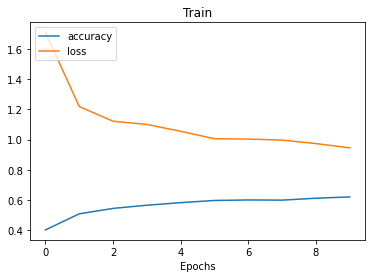

In [238]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.title('Train')
plt.show()


In [252]:
from IPython.display import SVG

img = list(data_dir.glob('*/*.jpg'))
import numpy as np
xhat = np.random.choice(img, (4))

In [253]:
xhat

array([WindowsPath('C:/Users/이지혜/.keras/datasets/flower_photos/dandelion/8223968_6b51555d2f_n.jpg'),
       WindowsPath('C:/Users/이지혜/.keras/datasets/flower_photos/dandelion/921252114_91e334b950.jpg'),
       WindowsPath('C:/Users/이지혜/.keras/datasets/flower_photos/roses/3713368809_eba7fa2fbf_m.jpg'),
       WindowsPath('C:/Users/이지혜/.keras/datasets/flower_photos/roses/4504220673_af754fcb40_n.jpg')],
      dtype=object)

In [254]:
import cv2
xbatch = []
yans = []
for i in xhat:
    yans.append((str(i).split('\\'))[6])
    img = plt.imread(str(i))
    img = np.resize(img,(1,input_height, input_width,3))/255.0
    xbatch.append(img)

In [255]:
yans

['dandelion', 'dandelion', 'roses', 'roses']

In [256]:
label = ['daisies', 'dandilion', 'roses', 'sunflowers', 'tulips']

In [258]:
for i in range(4):
    print(label[int(Model.predict_classes(xbatch[::][i]))])

dandilion
dandilion
dandilion
roses


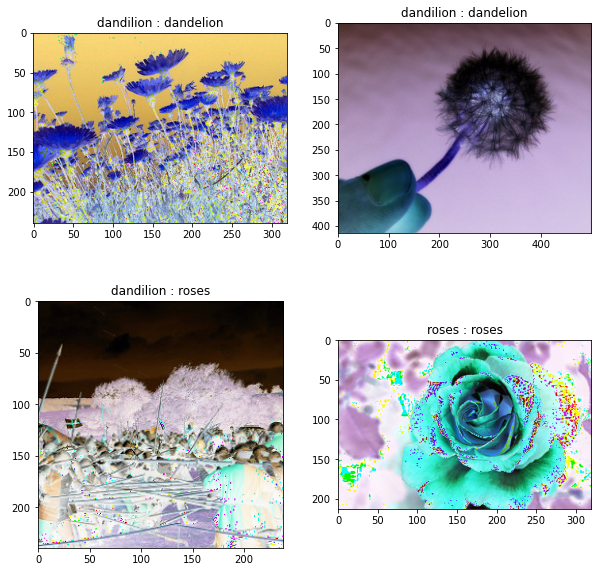

In [286]:
plt.figure(figsize = (10,10))
for i in range(len(xhat)):
    img = plt.imread(str(xhat[i]))
    plt.subplot(2,2,i+1)
    plt.imshow(img*255)
    plt.title(str(label[int(Model.predict_classes(xbatch[::][i]))]) + ' : ' + str(yans[i]))

- 필터는 처음에는 무작위로 구성이 되어 있지만 결국에는 학습이 되어서 가로 edge와 세로 edge각각에 반응하는 필터로 나뉘어서 학습이 된다. 
- 따라서 합성곱 계층의 필터는 edge와 같은 원시적인 정보를 추출할 수 있다.
- 그리고 AlexNet와 같이 Pooling과 Convolution을 여러 겹 쌓아서 결과를 출력하기도 하는데 이때 층이 깊어지면 깊어질 수록 더 복잡하고 추상화된 정보를 추출한다. 
    - 즉, 사물의 단순한 edge나 texture에 반응하다가 사물의 의미를 파악해 나가 결과적으로 Fast RNN처럼 시계열의 순환형 학습과도 접목이 되어서 객체 인식과 masking등이 가능해 지는 것이다.